#Installation
This installs the CatBoost library using pip


In [1]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.2 MB/s eta 0:00:00


#Importing libraries
*   NumPy: Used for numerical operations, arrays, and mathematical functions.
*   yfinance: Used for fetching historical financial data from Yahoo Finance.
*   Pandas: Used for data manipulation and analysis, particularly for handling financial time series data.
*   Matplotlib: Used for creating static 2D plots.
*   mpl_toolkits.mplot3d: Used for creating 3D plots with Matplotlib.
*   Plotly Express and Plotly Graph Objects: Used for creating interactive and expressive visualizations.
*   Seaborn: Used for statistical data visualization, enhancing the aesthetics of Matplotlib plots.
*   datetime: Used for working with dates and times.
*   scipy.stats.norm: Used for statistical operations, particularly for probability density functions.
*   ipywidgets: Used for creating interactive widgets, enhancing the interactivity of Jupyter notebooks.





In [2]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from datetime import datetime
from scipy.stats import norm
from ipywidgets import interact
from ipywidgets import widgets

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


# Data Acquistion


Importing the underlying data using yfinance.

In [3]:
ticker_symbol = '^NSEBANK'

# Specifying the date range for data retrieval
start_date = '2023-04-01'
end_date = '2023-12-31'

# Creating an empty DataFrame to store the downloaded data
uly=pd.DataFrame()

uly = yf.download(ticker_symbol, start=start_date, end=end_date)
uly.reset_index(inplace=True)

[*********************100%%**********************]  1 of 1 completed


Reading the csv files into the Pandas DataFrame.

In [4]:
call = pd.read_csv("call_option_data.csv")
put = pd.read_csv("put_option_data.csv")
call_extra=pd.read_csv("call_option_data_extra (1).csv")
put_extra=pd.read_csv("put_option_data_extra (1).csv")

#Data Preprocessing

Changing the date format of the data.

In [5]:
call['Date  '] = pd.to_datetime(call['Date  '], format="%d-%b-%Y")
call['Expiry  '] = pd.to_datetime(call['Expiry  '], format="%d-%b-%Y")
call['maturity'] = (call['Expiry  '] - call['Date  ']).dt.days


call_extra['Date  '] = pd.to_datetime(call_extra['Date  '], format="%d-%b-%Y")
call_extra['Expiry  '] = pd.to_datetime(call_extra['Expiry  '], format="%d-%b-%Y")
call_extra['maturity'] = (call_extra['Expiry  '] - call_extra['Date  ']).dt.days


put['Date  '] = pd.to_datetime(put['Date  '], format="%d-%b-%Y")
put['Expiry  '] = pd.to_datetime(put['Expiry  '], format="%d-%b-%Y")
put['maturity'] = (put['Expiry  '] - put['Date  ']).dt.days


put_extra['Date  '] = pd.to_datetime(put_extra['Date  '], format="%d-%b-%Y")
put_extra['Expiry  '] = pd.to_datetime(put_extra['Expiry  '], format="%d-%b-%Y")
put_extra['maturity'] = (put_extra['Expiry  '] - put_extra['Date  ']).dt.days



Adjusting the null points in the data to change "-" to zero values for Total contracts OI and Change in OI .
Open , High , Low are imputed by Close values in the same row when there are no option contracts traded.

In [6]:
columns_to_check = ['Open  ', 'High  ', 'Low  ']
replacement_column = 'Close  '

for column in columns_to_check:
    call[column] = call.apply(lambda row: row[replacement_column] if row[column] == '-' else row[column], axis=1)
    call_extra[column] = call_extra.apply(lambda row: row[replacement_column] if row[column] == '-' else row[column], axis=1)

# Updating 'put' DataFrame
for column in columns_to_check:
    put[column] = put.apply(lambda row: row[replacement_column] if row[column] == '-' else row[column], axis=1)
    put_extra[column] = put_extra.apply(lambda row: row[replacement_column] if row[column] == '-' else row[column], axis=1)

In [7]:
columns_to_check = ['No. of contracts  ', 'Open Int  ', 'Change in OI  ']

for column in columns_to_check:
    call[column] = call.apply(lambda row: 0 if row[column] == '-' else row[column], axis=1)
    call_extra[column] = call_extra.apply(lambda row: 0 if row[column] == '-' else row[column], axis=1)

# Updating 'put' DataFrame
for column in columns_to_check:
    put[column] = put.apply(lambda row: 0 if row[column] == '-' else row[column], axis=1)
    put_extra[column] = put_extra.apply(lambda row: 0 if row[column] == '-' else row[column], axis=1)

In [8]:
#Changing the data type of all the columns except Date, Expiry, Option type to float for easir computations
exclude_columns = ['Date  ', 'Expiry  ', 'Option type  ']


def convert_columns(df, exclude_columns):
     for column in df.columns.difference(exclude_columns):
         df[column] = pd.to_numeric(df[column], errors='coerce')  # Replace '-' with NaN and convert to float
     return df

#Applying the function to both 'call' and 'put' DataFrames
call = convert_columns(call, exclude_columns)
put = convert_columns(put, exclude_columns)
call_extra = convert_columns(call_extra, exclude_columns)
put_extra = convert_columns(put_extra, exclude_columns)



In [9]:
#fill NA values in underlying value by the Value above it

call['Underlying Value  '] = call['Underlying Value  '].fillna(method='ffill')
call_extra['Underlying Value  '] = call_extra['Underlying Value  '].fillna(method='ffill')
put['Underlying Value  '] = put['Underlying Value  '].fillna(method='ffill')
put_extra['Underlying Value  '] = put_extra['Underlying Value  '].fillna(method='ffill')

In [12]:
filtered_call = call
filtered_put = put

## Outlier Removal


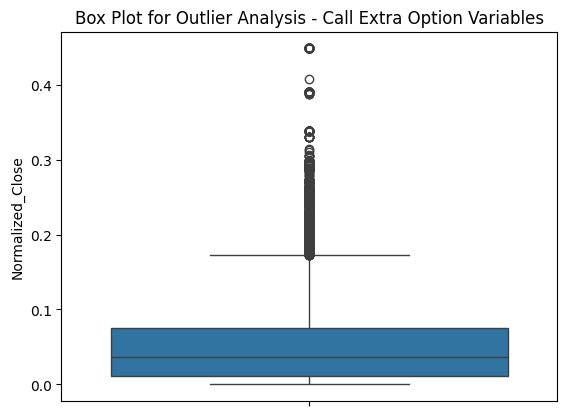

In [13]:
# Normalize closing prices by strike price
call_extra['Normalized_Close'] = call_extra['Close  '] / call_extra['Strike Price  ']
sns.boxplot(data=call_extra['Normalized_Close'])
plt.title('Box Plot for Outlier Analysis - Call Extra Option Variables')
plt.show()

In [15]:
# Group by expiration date
grouped_c_extra = call_extra.groupby('Expiry  ')

# Placeholder for outlier-free data
filtered_call_extra = pd.DataFrame()

for name, group in grouped_c_extra:
    # Within each group, calculating the IQR for normalized closing prices
    Q1 = group['Normalized_Close'].quantile(0.25)
    Q3 = group['Normalized_Close'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter outliers within the group
    filtered_group_c_extra = group[(group['Normalized_Close'] >= lower_bound) & (group['Normalized_Close'] <= upper_bound)]

    # Combine the filtered groups back into a single DataFrame
    filtered_call_extra = pd.concat([filtered_call_extra, filtered_group_c_extra], axis=0)


Date     Expiry   Option type    Strike Price     Open     High    \
3     2023-04-03 2023-04-06            CE         35000.0  5601.00  5601.00   
4     2023-04-03 2023-04-06            CE         35500.0  5119.95  5119.95   
5     2023-04-03 2023-04-06            CE         36000.0  3930.00  3930.00   
6     2023-04-03 2023-04-06            CE         36500.0  4217.30  4217.30   
7     2023-04-03 2023-04-06            CE         36900.0  3889.20  3889.20   
...          ...        ...           ...             ...      ...      ...   
37899 2023-06-30 2024-06-27            CE         46500.0  4378.40  4378.40   
37900 2023-06-30 2024-06-27            CE         48000.0  3721.40  3721.40   
37901 2023-06-30 2024-06-27            CE         49500.0  3142.65  3142.65   
37902 2023-06-30 2024-06-27            CE         51000.0  2637.55  2637.55   
37903 2023-06-30 2024-06-27            CE         52500.0  2200.65  2200.65   

         Low    Close    No. of contracts    Open Int    Change in OI    \
3      5601.00  5601.00                 1.0       225.0            25.0   
4      5119.95  5119.95                 0.0        50.0             0.0   
5      3930.00  3930.00                 0.0       100.0             0.0   
6      4217.30  4217.30                 1.0        50.0             0.0   
7      3889.20  3889.20                 0.0         0.0             0.0   
...        ...      ...                 ...         ...             ...   
37899  4378.40  4378.40                 0.0         0.0             0.0   
37900  3721.40  3721.40                 0.0         0.0             0.0   
37901  3142.65  3142.65                 0.0         0.0             0.0   
37902  2637.55  2637.55                 0.0         0.0             0.0   
37903  2200.65  2200.65                 0.0         0.0             0.0   

       Underlying Value    maturity  Normalized_Close  
3                40813.05         3          0.160029  
4                40813.05         3          0.144224  
5                40813.05         3          0.109167  
6                40813.05         3          0.115542  
7                40813.05         3          0.105398  
...                   ...       ...               ...  
37899            44747.35       363          0.094159  
37900            44747.35       363          0.077529  
37901            44747.35       363          0.063488  
37902            44747.35       363          0.051717  
37903            44747.35       363          0.041917  

[36488 rows x 14 columns]

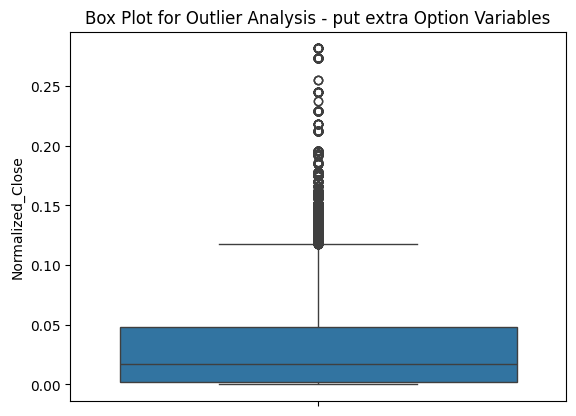

In [14]:
put_extra['Normalized_Close'] = put_extra['Close  '] / put_extra['Strike Price  ']
sns.boxplot(data=put_extra['Normalized_Close'])
plt.title('Box Plot for Outlier Analysis - put extra Option Variables')
plt.show()


In [16]:
grouped_p_extra = put_extra.groupby('Expiry  ')

# Placeholder for outlier-free data
filtered_put_extra = pd.DataFrame()

for name, group in grouped_p_extra:
    # Within each group, calculate the IQR for normalized closing prices
    Q1 = group['Normalized_Close'].quantile(0.25)
    Q3 = group['Normalized_Close'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter outliers within the group
    filtered_group_p_extra = group[(group['Normalized_Close'] >= lower_bound) & (group['Normalized_Close'] <= upper_bound)]

    # Combine the filtered groups back into a single DataFrame
    filtered_put_extra = pd.concat([filtered_put_extra, filtered_group_p_extra], axis=0)


Date     Expiry   Option type    Strike Price     Open     High    \
0     2023-04-03 2023-04-06            PE         33500.0     2.45     2.75   
1     2023-04-03 2023-04-06            PE         34000.0     2.95     3.00   
2     2023-04-03 2023-04-06            PE         34500.0     3.05     3.20   
3     2023-04-03 2023-04-06            PE         35000.0     2.90     3.35   
4     2023-04-03 2023-04-06            PE         35500.0     4.00     4.00   
...          ...        ...           ...             ...      ...      ...   
37900 2023-06-30 2024-06-27            PE         46500.0  3333.15  3333.15   
37901 2023-06-30 2024-06-27            PE         48000.0  4072.35  4072.35   
37902 2023-06-30 2024-06-27            PE         49500.0  4889.80  4889.80   
37903 2023-06-30 2024-06-27            PE         51000.0  5780.95  5780.95   
37904 2023-06-30 2024-06-27            PE         52500.0  6740.20  6740.20   

         Low    Close    No. of contracts    Open Int    Change in OI    \
0         1.30     1.40            216508.0    824825.0        205325.0   
1         1.40     1.55             74626.0    269100.0         22575.0   
2         1.65     1.85             47432.0    207825.0         12125.0   
3         1.75     1.90             60487.0    343900.0        -81450.0   
4         1.95     2.20             53917.0    238700.0         -4250.0   
...        ...      ...                 ...         ...             ...   
37900  3333.15  3333.15                 0.0         0.0             0.0   
37901  4072.35  4072.35                 0.0         0.0             0.0   
37902  4889.80  4889.80                 0.0         0.0             0.0   
37903  5780.95  5780.95                 0.0         0.0             0.0   
37904  6740.20  6740.20                 0.0         0.0             0.0   

       Underlying Value    maturity  Normalized_Close  
0                40813.05         3          0.000042  
1                40813.05         3          0.000046  
2                40813.05         3          0.000054  
3                40813.05         3          0.000054  
4                40813.05         3          0.000062  
...                   ...       ...               ...  
37900            44747.35       363          0.071681  
37901            44747.35       363          0.084841  
37902            44747.35       363          0.098784  
37903            44747.35       363          0.113352  
37904            44747.35       363          0.128385  

[35495 rows x 14 columns]





# Data Visualisation

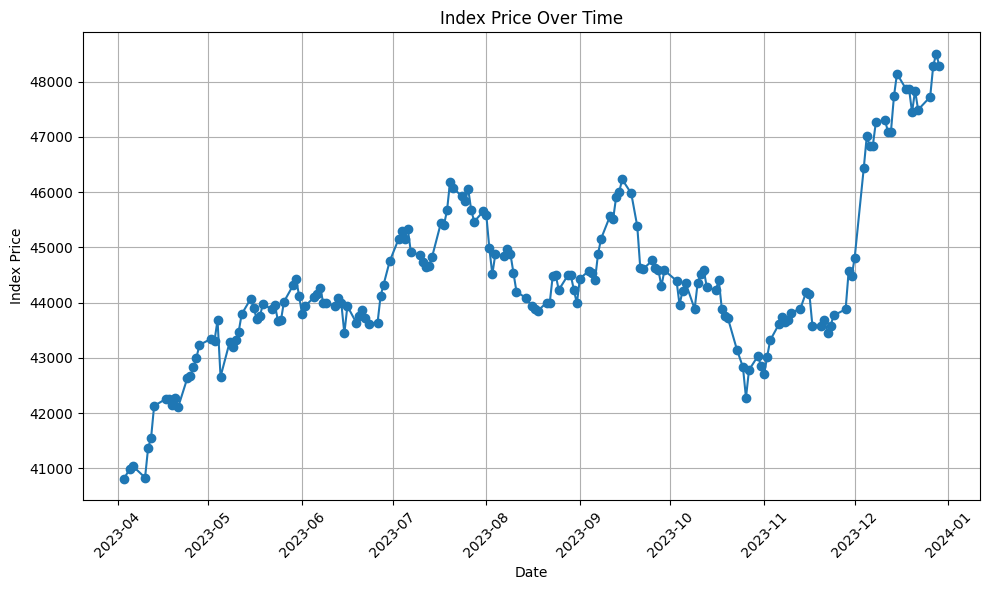

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(uly['Date'], uly['Close'], marker='o', linestyle='-')
plt.title('Index Price Over Time')
plt.xlabel('Date')
plt.ylabel('Index Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
atm_dates, atm_closes = [], []
itm_dates, itm_closes = [], []
otm_dates, otm_closes = [], []

for date in filtered_call['Date  '].unique():  # Adjusting 'Date  '
    df_on_date = filtered_call[filtered_call['Date  '] == date]  # Adjusting 'Date  '

    # Determine ATM, ITM, OTM strikes (simplified approach)
    atm_strike = df_on_date.iloc[(df_on_date['Strike Price  '] - df_on_date['Underlying Value  '].iloc[0]).abs().argsort()[:1]]['Strike Price  '].values[0]  # Adjusting 'Strike Price  ' and 'Underlying Value  '
    itm_strike = df_on_date[df_on_date['Strike Price  '] < atm_strike]['Strike Price  '].max()  # One level below ATM, adjusting 'Strike Price  '
    otm_strike = df_on_date[df_on_date['Strike Price  '] > atm_strike]['Strike Price  '].min()  # One level above ATM, adjusting 'Strike Price  '

    # Filter for these strikes and collect data
    atm_close = df_on_date[df_on_date['Strike Price  '] == atm_strike]['Close  '].values[0] if not df_on_date[df_on_date['Strike Price  '] == atm_strike].empty else None
    itm_close = df_on_date[df_on_date['Strike Price  '] == itm_strike]['Close  '].values[0] if not df_on_date[df_on_date['Strike Price  '] == itm_strike].empty else None
    otm_close = df_on_date[df_on_date['Strike Price  '] == otm_strike]['Close  '].values[0] if not df_on_date[df_on_date['Strike Price  '] == otm_strike].empty else None
    if atm_close is not None:
        atm_dates.append(date)
        atm_closes.append(atm_close)
    if itm_close is not None:
        itm_dates.append(date)
        itm_closes.append(itm_close)
    if otm_close is not None:
        otm_dates.append(date)
        otm_closes.append(otm_close)
def update_plot(show_atm, show_itm, show_otm):
    plt.figure(figsize=(14, 8))

    if show_atm:
        plt.plot(atm_dates, atm_closes, label='ATM', marker='o', linestyle='-', color='blue')
    if show_itm:
        plt.plot(itm_dates, itm_closes, label='ITM', marker='x', linestyle='-', color='green')
    if show_otm:
        plt.plot(otm_dates, otm_closes, label='OTM', marker='^', linestyle='-', color='red')

    plt.title('Call Option Premium for Key Strikes Over Time')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
atm_checkbox = widgets.Checkbox(value=True, description='ATM')
itm_checkbox = widgets.Checkbox(value=True, description='ITM')
otm_checkbox = widgets.Checkbox(value=True, description='OTM')

# Interactive widget to update the plot based on checkbox states
widgets.interactive(update_plot, show_atm=atm_checkbox, show_itm=itm_checkbox, show_otm=otm_checkbox)


interactive(children=(Checkbox(value=True, description='ATM'), Checkbox(value=True, description='ITM'), Checkb…

In [19]:
fig = px.scatter_3d(call, x='Strike Price  ', y='Expiry  ', z='Close  ',
                    labels={'Close': 'Premium'},
                    title='3D Scatter Plot - Strike Price, Expiry, and Premium')
fig.show()

In [20]:
fig = px.scatter_3d(call, x='Strike Price  ', y='Underlying Value  ', z='Close  ',
                    labels={'Close': 'Premium'},
                    title='3D Scatter Plot - Strike Price, Expiry, and Premium')
fig.show()

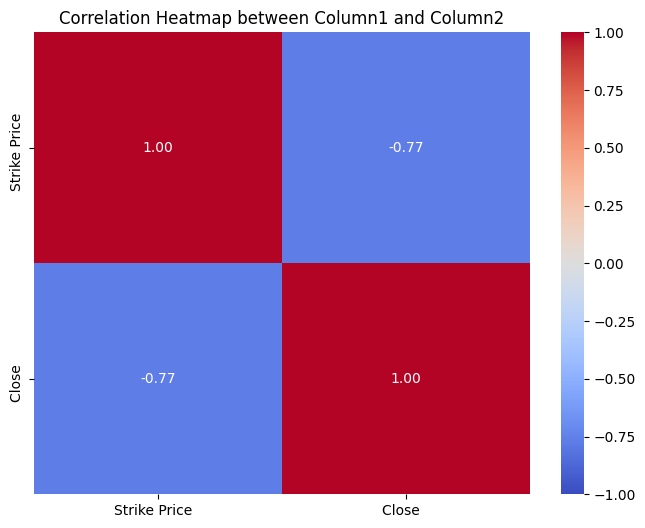

In [21]:
correlation_matrix = filtered_call[['Strike Price  ', 'Close  ']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

plt.title('Correlation Heatmap between Column1 and Column2')
plt.show()

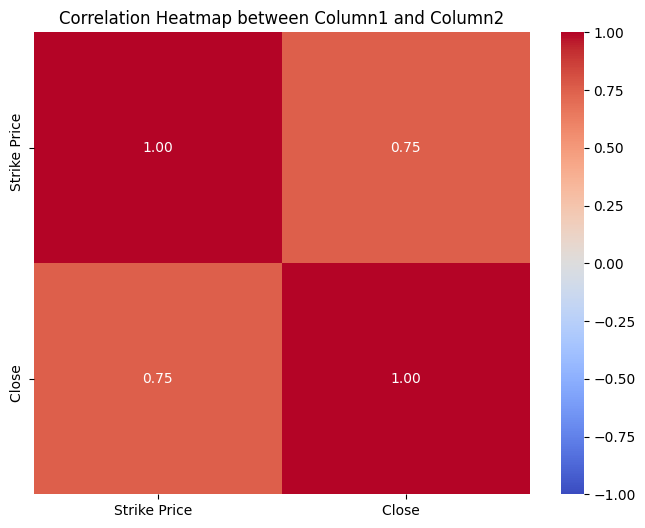

In [22]:
correlation_matrix = filtered_put[['Strike Price  ', 'Close  ']].corr()

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

# Set plot title
plt.title('Correlation Heatmap between Column1 and Column2')
plt.show()

#Feature Calculations



 **R**.**V**

**1**.**EMA** **Returns**

In [26]:
returns=[0.003]
close = uly['Close']
for a in range(1,len(close)):
  ret = (close[a] - close[a-1])/close[a-1]
  returns.append(ret)

uly['Return'] = returns

def calculate_ema_returns(df, span):
    df['EMA'] = df['Return'].ewm(span=span, adjust=False).mean()
    return df.dropna()

uly_ema_returns = calculate_ema_returns(uly, span=20)

# Display the result
EMA=pd.DataFrame()
EMA['Date  ']=uly['Date']
EMA['ema'] =uly_ema_returns['EMA']
EMA['Date  '] = pd.to_datetime(EMA['Date  '], format="%Y-%m-%d")

EMA.head()

Date         ema
0 2023-04-03  0.003000
1 2023-04-05  0.003149
2 2023-04-06  0.002946
3 2023-04-10  0.002186
4 2023-04-11  0.003219

Merging put and call tables


In [27]:
put_call = pd.merge(filtered_call, filtered_put, on=['Date  ', 'Expiry  ', 'Strike Price  ','Underlying Value  '], how='inner',suffixes=('_call', '_put'))
put_call

Date     Expiry   Option type  _call  Strike Price    Open  _call  \
0     2023-07-03 2023-07-06                 CE         37500.0      6556.85   
1     2023-07-03 2023-07-06                 CE         38000.0      6067.95   
2     2023-07-03 2023-07-06                 CE         38500.0      5650.00   
3     2023-07-03 2023-07-06                 CE         39000.0      5325.00   
4     2023-07-03 2023-07-06                 CE         39500.0      5230.10   
...          ...        ...                ...             ...          ...   
78958 2023-12-29 2024-12-26                 CE         49500.0      4936.25   
78959 2023-12-29 2024-12-26                 CE         51000.0      4181.70   
78960 2023-12-29 2024-12-26                 CE         52500.0      3513.25   
78961 2023-12-29 2024-12-26                 CE         54000.0      2928.20   
78962 2023-12-29 2024-12-26                 CE         55500.0      2421.65   

       High  _call  Low  _call  Close  _call  No. of contracts  _call  \
0          6556.85     6556.85       6556.85                      0.0   
1          6067.95     6067.95       6067.95                      0.0   
2          5650.00     5650.00       5650.00                      0.0   
3          5325.00     5325.00       5325.00                      0.0   
4          5230.10     5230.10       5230.10                      0.0   
...            ...         ...           ...                      ...   
78958      4936.25     4936.25       4936.25                      0.0   
78959      4181.70     4181.70       4181.70                      0.0   
78960      3513.25     3513.25       3513.25                      0.0   
78961      2928.20     2928.20       2928.20                      0.0   
78962      2421.65     2421.65       2421.65                      0.0   

       Open Int  _call  ...  maturity_call  Option type  _put  Open  _put  \
0                  0.0  ...              3                 PE        4.45   
1                  0.0  ...              3                 PE        3.65   
2                100.0  ...              3                 PE        4.75   
3                125.0  ...              3                 PE        4.95   
4               1025.0  ...              3                 PE        5.30   
...                ...  ...            ...                ...         ...   
78958              0.0  ...            363                 PE     2461.35   
78959              0.0  ...            363                 PE     3101.75   
78960              0.0  ...            363                 PE     3828.25   
78961              0.0  ...            363                 PE     4638.15   
78962              0.0  ...            363                 PE     5526.60   

      High  _put  Low  _put  Close  _put  No. of contracts  _put  \
0           5.60       2.85         3.70                323130.0   
1           5.95       3.40         4.50                138440.0   
2           6.55       3.20         5.45                 91321.0   
3           7.25       4.40         5.85                147668.0   
4           7.60       4.15         5.85                127925.0   
...          ...        ...          ...                     ...   
78958    2461.35    2461.35      2461.35                     0.0   
78959    3101.75    3101.75      3101.75                     0.0   
78960    3828.25    3828.25      3828.25                     0.0   
78961    4638.15    4638.15      4638.15                     0.0   
78962    5526.60    5526.60      5526.60                     0.0   

       Open Int  _put  Change in OI  _put  maturity_put  
0           1285750.0            276300.0             3  
1            287375.0            151975.0             3  
2            476550.0            470175.0             3  
3           1091575.0            384375.0             3  
4            911475.0            304850.0             3  
...               ...                 ...           ...  
78958             0.0               

In [28]:
put_call_extra = pd.merge(filtered_call_extra, filtered_put_extra, on=['Date  ', 'Expiry  ', 'Strike Price  ','Underlying Value  '], how='inner',suffixes=('_call_extra', '_put_extra'))
put_call_extra

Date     Expiry   Option type  _call_extra  Strike Price    \
0     2023-04-03 2023-04-06                       CE         35000.0   
1     2023-04-03 2023-04-06                       CE         35500.0   
2     2023-04-03 2023-04-06                       CE         36000.0   
3     2023-04-03 2023-04-06                       CE         36500.0   
4     2023-04-03 2023-04-06                       CE         36900.0   
...          ...        ...                      ...             ...   
34073 2023-06-30 2024-06-27                       CE         46500.0   
34074 2023-06-30 2024-06-27                       CE         48000.0   
34075 2023-06-30 2024-06-27                       CE         49500.0   
34076 2023-06-30 2024-06-27                       CE         51000.0   
34077 2023-06-30 2024-06-27                       CE         52500.0   

       Open  _call_extra  High  _call_extra  Low  _call_extra  \
0                5601.00            5601.00           5601.00   
1                5119.95            5119.95           5119.95   
2                3930.00            3930.00           3930.00   
3                4217.30            4217.30           4217.30   
4                3889.20            3889.20           3889.20   
...                  ...                ...               ...   
34073            4378.40            4378.40           4378.40   
34074            3721.40            3721.40           3721.40   
34075            3142.65            3142.65           3142.65   
34076            2637.55            2637.55           2637.55   
34077            2200.65            2200.65           2200.65   

       Close  _call_extra  No. of contracts  _call_extra  \
0                 5601.00                            1.0   
1                 5119.95                            0.0   
2                 3930.00                            0.0   
3                 4217.30                            1.0   
4                 3889.20                            0.0   
...                   ...                            ...   
34073             4378.40                            0.0   
34074             3721.40                            0.0   
34075             3142.65                            0.0   
34076             2637.55                            0.0   
34077             2200.65                            0.0   

       Open Int  _call_extra  ...  Option type  _put_extra  Open  _put_extra  \
0                      225.0  ...                       PE              2.90   
1                       50.0  ...                       PE              4.00   
2                      100.0  ...                       PE              4.90   
3                       50.0  ...                       PE              3.95   
4                        0.0  ...                       PE              5.00   
...                      ...  ...                      ...               ...   
34073                    0.0  ...                       PE           3333.15   
34074                    0.0  ...                       PE           4072.35   
34075                    0.0  ...                       PE           4889.80   
34076                    0.0  ...                       PE           5780.95   
34077                    0.0  ...                       PE           6740.20   

       High  _put_extra  Low  _put_extra Close  _put_extra  \
0                  3.35             1.75              1.90   
1                  4.00             1.95              2.20   
2                  4.90             1.95              2.25   
3                  4.35             2.05              2.40   
4                  5.00             2.15              2.65   
...                 ...              ...               ...   
34073           3333.15          3333.15           3333.15   
34074           4072.35          4072.35           4072.35   
34075           4889.80          4889.80           4889.80   
34076           5780.95          5780.95           5780.95   


**2. EMA put-to-call ratio**

In [29]:
pcr_un=pd.DataFrame()
pcr_un['Date  ']=put_call['Date  ']
pcr_un['No. of contracts _call']=put_call['No. of contracts  _call']
pcr_un['No. of contracts _put']=put_call['No. of contracts  _put']

In [30]:
pcr_un_extra=pd.DataFrame()
pcr_un_extra['Date  ']=put_call_extra['Date  ']
pcr_un_extra['No. of contracts _call_extra']=put_call_extra['No. of contracts  _call_extra']
pcr_un_extra['No. of contracts _put_extra']=put_call_extra['No. of contracts  _put_extra']

In [31]:
pcr_un['No. of contracts_call'] = pd.to_numeric(pcr_un['No. of contracts _call'], errors='coerce')
pcr_un['No. of contracts_put'] = pd.to_numeric(pcr_un['No. of contracts _put'], errors='coerce')

# Optionally, you can fill NaN values with 0 if that makes sense for your data
pcr_un['No. of contracts_call'].fillna(0, inplace=True)
pcr_un['No. of contracts_put'].fillna(0, inplace=True)

# Group by 'Date' and sum the numeric columns
pcr = pcr_un.groupby('Date  ').agg({'No. of contracts_call': 'sum', 'No. of contracts_put': 'sum'}).reset_index()
pcr['put_call_ratio']=pcr['No. of contracts_put']/pcr['No. of contracts_call']

def calculate_ema_pcr(df, span):
    df['EMA_pcr'] = df['put_call_ratio'].ewm(span=span, adjust=False).mean()
    return df.dropna()

# Replace '20' with your desired EMA span
uly_ema_returns = calculate_ema_pcr(pcr, span=20)

#value_to_delete = 2023-11-12

#pcr = pcr[pcr['Date  '] != value_to_delete]
pcr['Date  '] = pd.to_datetime(pcr['Date  '], format="%d-%b-%Y")
pcr

pcr['os vol'] = pcr['No. of contracts_call']+pcr['No. of contracts_put']
pcr.head()

Date    No. of contracts_call  No. of contracts_put  put_call_ratio  \
0 2023-07-03             45586439.0            36994521.0        0.811525   
1 2023-07-04             52849854.0            47875906.0        0.905885   
2 2023-07-05             62140722.0            64256595.0        1.034050   
3 2023-07-06            148139030.0           134272206.0        0.906393   
4 2023-07-07             34779996.0            34369647.0        0.988202   

    EMA_pcr       os vol  
0  0.811525   82580960.0  
1  0.820511  100725760.0  
2  0.840848  126397317.0  
3  0.847091  282411236.0  
4  0.860530   69149643.0

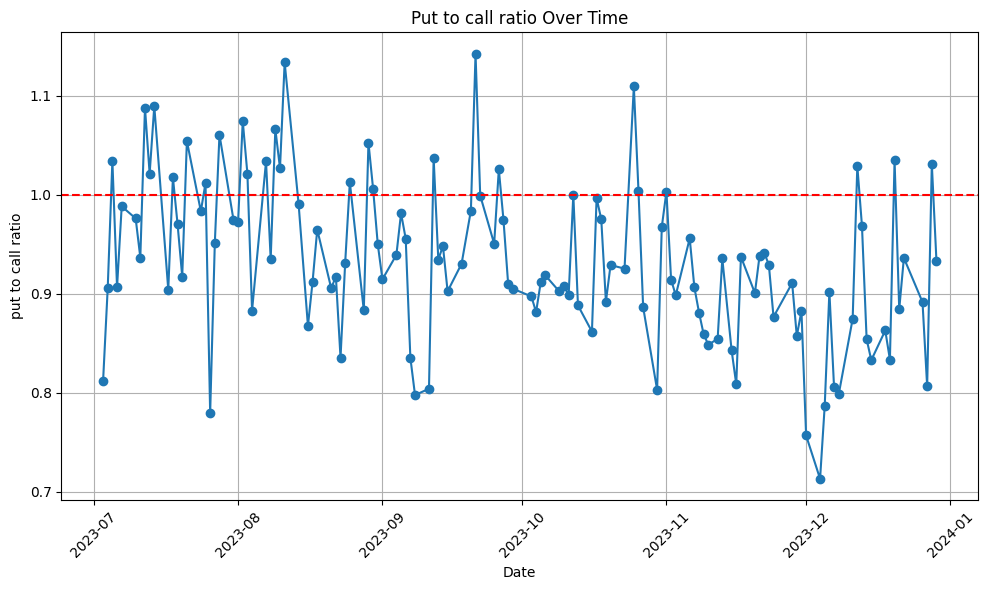

In [32]:
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.plot(pcr['Date  '], pcr['put_call_ratio'], marker='o', linestyle='-')
plt.title('Put to call ratio Over Time')
plt.xlabel('Date')
plt.ylabel('put to call ratio')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.axhline(y=1, color='r', linestyle='--')
plt.show()

In [33]:
pcr_un_extra['No. of contracts_call_extra'] = pd.to_numeric(pcr_un_extra['No. of contracts _call_extra'], errors='coerce')
pcr_un_extra['No. of contracts_put_extra'] = pd.to_numeric(pcr_un_extra['No. of contracts _put_extra'], errors='coerce')

# Optionally, you can fill NaN values with 0 if that makes sense for your data
pcr_un_extra['No. of contracts_call_extra'].fillna(0, inplace=True)
pcr_un_extra['No. of contracts_put_extra'].fillna(0, inplace=True)

# Group by 'Date' and sum the numeric columns
pcr_extra = pcr_un_extra.groupby('Date  ').agg({'No. of contracts_call_extra': 'sum', 'No. of contracts_put_extra': 'sum'}).reset_index()
pcr_extra['put_call_ratio']=pcr_extra['No. of contracts_put_extra']/pcr_extra['No. of contracts_call_extra']

def calculate_ema_pcr(df, span):
    df['EMA_pcr'] = df['put_call_ratio'].ewm(span=span, adjust=False).mean()
    return df.dropna()

# Replace '20' with your desired EMA span
uly_ema_returns_extra = calculate_ema_pcr(pcr_extra, span=20)

#value_to_delete = 2023-11-12

#pcr = pcr[pcr['Date  '] != value_to_delete]
pcr_extra['Date  '] = pd.to_datetime(pcr_extra['Date  '], format="%d-%b-%Y")
pcr

pcr_extra['os vol'] = pcr_extra['No. of contracts_call_extra']+pcr_extra['No. of contracts_put_extra']
pcr_extra.head()

Date    No. of contracts_call_extra  No. of contracts_put_extra  \
0 2023-04-03                   27595866.0                  27019431.0   
1 2023-04-05                   45475497.0                  39859882.0   
2 2023-04-06                  125376259.0                 122020483.0   
3 2023-04-10                   32358111.0                  31537501.0   
4 2023-04-11                   37501772.0                  34916796.0   

   put_call_ratio   EMA_pcr       os vol  
0        0.979112  0.979112   54615297.0  
1        0.876513  0.969340   85335379.0  
2        0.973234  0.969711  247396742.0  
3        0.974640  0.970181   63895612.0  
4        0.931071  0.966456   72418568.0

IMPLIED VOLATILITY using Black Scholes

In [25]:
def annual_vol(df):

    log_return = np.log(1 + df['Close'].pct_change())
    log_return = log_return.dropna()
    daily_vol = log_return.std()
    vol = daily_vol * np.sqrt(252)

    return vol

In [24]:
#Defining Black Scholes model to calculate IV
def blackScholes(S, K, r, T, sigma, type):
    "Calculate Black Scholes option price for a call/put"
    d1 = (np.log(S/K) + (r + sigma**2/2)* T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)


    if type == "c":
            price = S * norm.cdf(d1, 0, 1) - K * np.exp(-r * T) * norm.cdf(d2, 0, 1)
    elif type == "p":
            price = K * np.exp(-r * T) * norm.cdf(-d2, 0, 1) - S * norm.cdf(-d1, 0, 1)

    return price

In [34]:
def implied_volatility(S, K, r, T, market_price, type, tolerance=0.0001, max_iterations=100):

    # Initial lower and upper bounds for volatility
    sigma_lower = 0.0001
    sigma_upper = 1

    # Initial guess for sigma
    sigma = (sigma_lower + sigma_upper) / 2

    for i in range(max_iterations):
        # Calculate the price with the current guess of volatility
        price = blackScholes(S, K, r, T, sigma, type)

        # Compare the Black Scholes price with the market price
        if price > market_price:
            sigma_upper = sigma
        else:
            sigma_lower = sigma

        # Recalculate sigma and check if within tolerance
        prev_sigma = sigma
        sigma = (sigma_lower + sigma_upper) / 2
        if abs(price - market_price) < tolerance or abs(prev_sigma - sigma) < tolerance:
            return sigma
    return sigma


<ipython-input-24-2a33c5d13456>:3: RuntimeWarning:

divide by zero encountered in double_scalars

<ipython-input-24-2a33c5d13456>:3: RuntimeWarning:

divide by zero encountered in double_scalars



In [ ]:
filtered_call['IV'] = filtered_call.apply(lambda row: implied_volatility(row['Underlying Value  '], row['Strike Price  '], 0.07148, row['maturity']/365, row['Close  '], type="c"), axis=1)
filtered_call_extra['IV'] = filtered_call_extra.apply(lambda row: implied_volatility(row['Underlying Value  '], row['Strike Price  '], 0.07148, row['maturity']/365, row['Close  '], type="c"), axis=1)

In [35]:
filtered_put['IV'] = filtered_put.apply(lambda row: implied_volatility(row['Underlying Value  '], row['Strike Price  '], 0.07148, row['maturity']/365, row['Close  '], type="p"), axis=1)
filtered_put_extra['IV'] = filtered_put_extra.apply(lambda row: implied_volatility(row['Underlying Value  '], row['Strike Price  '], 0.07148, row['maturity']/365, row['Close  '], type="p"), axis=1)

<ipython-input-24-2a33c5d13456>:3: RuntimeWarning:

divide by zero encountered in double_scalars

<ipython-input-24-2a33c5d13456>:3: RuntimeWarning:

divide by zero encountered in double_scalars



In [36]:
##Plotting the IV Surface wrt strike price and expiry
fig = px.scatter_3d(filtered_call, x='Strike Price  ', y='Expiry  ', z='IV',
                    title='3D Scatter Plot - Strike Price, Expiry, and IV levels')
fig.show()

**4.I.V Spread**

Calculting The IV spread for both the training and the test data

In [37]:
filtered_call.reset_index(drop=True, inplace=True)
filtered_put.reset_index(drop=True, inplace=True)

iv_data = pd.DataFrame()
iv_data[' call ATM_Difference'] = abs(filtered_call['Underlying Value  '] - filtered_call['Strike Price  '])
iv_data['Date'] = filtered_call['Date  ']
iv_data['call IV'] = filtered_call['IV']
iv_data = iv_data.sort_values(by=['Date', ' call ATM_Difference'])
iv_data = iv_data.drop_duplicates(subset=['Date'], keep='first')
iv_data = iv_data[['Date', 'call IV']]

iv_data[' put ATM_Difference'] = abs(filtered_put['Underlying Value  '] - filtered_put['Strike Price  '])

iv_data['put IV'] = filtered_put['IV']
iv_data = iv_data.sort_values(by=['Date', ' put ATM_Difference'])
iv_data = iv_data.drop_duplicates(subset=['Date'], keep='first')
iv_data = iv_data[['Date', 'call IV', 'put IV']]
iv_data['IV_spread'] = abs(iv_data['put IV'] - iv_data['call IV'])

iv_data['Date'] = pd.to_datetime(iv_data['Date'], format="%d-%b-%Y")
iv_data.reset_index(drop=True, inplace=True)
iv_data.set_index('Date')

call IV    put IV  IV_spread
Date                                     
2023-07-03  0.129299  0.145532   0.016234
2023-07-04  0.132716  0.154565   0.021848
2023-07-05  0.153588  0.162132   0.008544
2023-07-06  0.999939  0.999939   0.000000
2023-07-07  0.108427  0.120999   0.012572
...              ...       ...        ...
2023-12-22  0.144556  0.149804   0.005248
2023-12-26  0.192647  0.150537   0.042110
2023-12-27  0.199604  0.381715   0.182111
2023-12-28  0.999939  0.264539   0.735400
2023-12-29  0.156762  0.346440   0.189678

[124 rows x 3 columns]

In [38]:
filtered_call_extra.reset_index(drop=True, inplace=True)
filtered_put_extra.reset_index(drop=True, inplace=True)

iv_data_extra = pd.DataFrame()
iv_data_extra[' call ATM_Difference'] = abs(filtered_call_extra['Underlying Value  '] - filtered_call_extra['Strike Price  '])
iv_data_extra['Date'] = filtered_call_extra['Date  ']
iv_data_extra['call IV'] = filtered_call_extra['IV']
iv_data_extra = iv_data_extra.sort_values(by=['Date', ' call ATM_Difference'])
iv_data_extra = iv_data_extra.drop_duplicates(subset=['Date'], keep='first')
iv_data_extra = iv_data_extra[['Date', 'call IV']]

iv_data_extra[' put ATM_Difference'] = abs(filtered_put_extra['Underlying Value  '] - filtered_put_extra['Strike Price  '])

iv_data_extra['put IV'] = filtered_put_extra['IV']
iv_data_extra = iv_data_extra.sort_values(by=['Date', ' put ATM_Difference'])
iv_data_extra = iv_data_extra.drop_duplicates(subset=['Date'], keep='first')
iv_data_extra = iv_data_extra[['Date', 'call IV', 'put IV']]
iv_data_extra['IV_spread'] = abs(iv_data_extra['put IV'] - iv_data_extra['call IV'])

iv_data_extra['Date'] = pd.to_datetime(iv_data_extra['Date'], format="%d-%b-%Y")
iv_data_extra.reset_index(drop=True, inplace=True)
iv_data_extra.set_index('Date')

call IV    put IV  IV_spread
Date                                     
2023-04-03  0.136866  0.159691   0.022825
2023-04-05  0.161522  0.185201   0.023679
2023-04-06  0.999939  0.000161   0.999778
2023-04-10  0.146631  0.097930   0.048701
2023-04-11  0.130519  0.231827   0.101308
2023-04-12  0.141870  0.281383   0.139512
2023-04-13  0.000161  0.999939   0.999778
2023-04-17  0.149682  0.722379   0.572697
2023-04-18  0.152856  0.999939   0.847083
2023-04-19  0.146997  0.162864   0.015868
2023-04-20  0.999939  0.136012   0.863927
2023-04-21  0.116482  0.269299   0.152817
2023-04-24  0.130153  0.999939   0.869786
2023-04-25  0.130641  0.463738   0.333097
2023-04-26  0.127590  0.339361   0.211771
2023-04-27  0.999939  0.375368   0.624571
2023-04-28  0.081574  0.273083   0.191509
2023-05-02  0.140528  0.349003   0.208475
2023-05-03  0.158592  0.470573   0.311981
2023-05-04  0.999939  0.364504   0.635434
2023-05-05  0.135035  0.253310   0.118274
2023-05-08  0.153588  0.266370   0.112782
2023-05-09  0.152978  0.252211   0.099233
2023-05-10  0.164451  0.191792   0.027341
2023-05-11  0.999939  0.347538   0.652401
2023-05-12  0.107938  0.160057   0.052119
2023-05-15  0.230607  0.283946   0.053339
2023-05-16  0.151757  0.329352   0.177595
2023-05-17  0.153222  0.183126   0.029904
2023-05-18  0.999939  0.167137   0.832802
2023-05-19  0.100615  0.397826   0.297211
2023-05-22  0.147485  0.363040   0.215555
2023-05-23  0.146265  0.159325   0.013060
2023-05-24  0.167747  0.461541   0.293794
2023-05-25  0.999939  0.390991   0.608948
2023-05-26  0.106230  0.202411   0.096182
2023-05-29  0.129054  0.153954   0.024900
2023-05-30  0.112577  0.295298   0.182721
2023-05-31  0.143335  0.331183   0.187847
2023-06-01  0.999939  0.342778   0.657161
2023-06-02  0.126857  0.302621   0.175764
2023-06-05  0.150048  0.310433   0.160384
2023-06-06  0.128810  0.149316   0.020506
2023-06-07  0.131496  0.141382   0.009887
2023-06-08  0.999939  0.489248   0.510691
2023-06-09  0.111112  0.388428   0.277316
2023-06-12  0.149804  0.343144   0.193340
2023-06-13  0.138087  0.278331   0.140245
2023-06-14  0.187886  0.318000   0.130114
2023-06-15  0.999939  0.367678   0.632261
2023-06-16  0.103910  0.326666   0.222756
2023-06-19  0.156395  0.343755   0.187359
2023-06-20  0.127346  0.340581   0.213236
2023-06-21  0.137965  0.465691   0.327726
2023-06-22  0.999939  0.440425   0.559514
2023-06-23  0.104277  0.083038   0.021238
2023-06-26  0.127101  0.194966   0.067864
2023-06-27  0.077424  0.096953   0.019529
2023-06-28  0.000161  0.368777   0.368615
2023-06-30  0.090118  0.414426   0.324308



Through our analysis we found out that the Options data had one extra day compared to Underlying so removing that from our analysis

In [39]:
missing_rows_extra = iv_data_extra[~iv_data_extra['Date'].isin(uly['Date'])]
missing_rows_extra

Empty DataFrame
Columns: [Date, call IV, put IV, IV_spread]
Index: []

**Merged dataframe to aggregate all the features**

In [131]:
merged=pd.merge(pcr, EMA, on=['Date  '], how='inner')
merged['os vol'] = merged['os vol']/uly['Volume']
merged = pd.merge(merged,iv_data,left_on=['Date  '],right_on = ['Date'], how='inner')
columns_to_drop = ['Date  ','No. of contracts_call','No. of contracts_put','put_call_ratio','Date']
merged.drop(columns=columns_to_drop, inplace=True)
merged.head()

EMA_pcr       os vol       ema   call IV    put IV  IV_spread
0  0.811525   493.020657  0.002604  0.129299  0.145532   0.016234
1  0.820511   567.788952  0.002658  0.132716  0.154565   0.021848
2  0.840848   643.243344  0.002090  0.153588  0.162132   0.008544
3  0.847091  1835.030773  0.002288  0.999939  0.999939   0.000000
4  0.860530   315.463700  0.001199  0.108427  0.120999   0.012572

In [132]:
merged_extra=pd.merge(pcr_extra, EMA, on=['Date  '], how='inner')
merged_extra['os vol'] = merged_extra['os vol']/uly['Volume']
merged_extra = pd.merge(merged_extra,iv_data_extra,left_on=['Date  '],right_on = ['Date'], how='inner')
columns_to_drop = ['Date  ','No. of contracts_call_extra','No. of contracts_put_extra','put_call_ratio','Date']
merged_extra.drop(columns=columns_to_drop, inplace=True)
merged_extra.head()

EMA_pcr       os vol       ema   call IV    put IV  IV_spread
0  0.979112   326.061475  0.003000  0.136866  0.159691   0.022825
1  0.969340   481.033703  0.003149  0.161522  0.185201   0.023679
2  0.969711  1259.016499  0.002946  0.999939  0.000161   0.999778
3  0.970181   415.176166  0.002186  0.146631  0.097930   0.048701
4  0.966456   330.376679  0.003219  0.130519  0.231827   0.101308

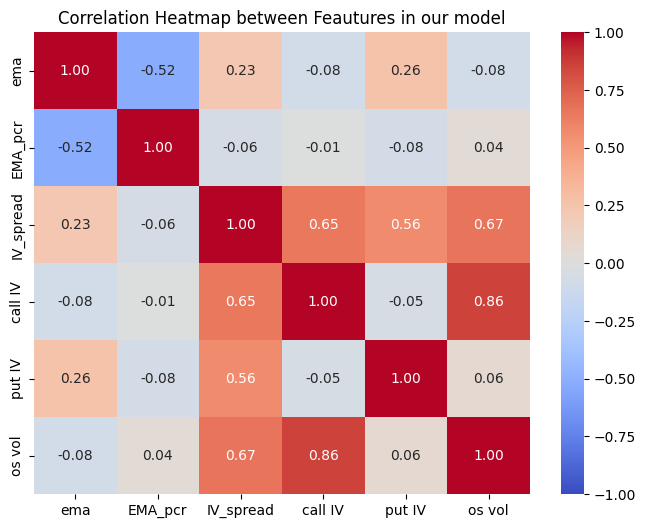

In [133]:
##correlation heat map to make sure the features are not highly co related
correlation_matrix = merged_extra[['ema', 'EMA_pcr','IV_spread','call IV','put IV','os vol']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

#plotting the map
plt.title('Correlation Heatmap between Feautures in our model')
plt.show()

# Final data and model fitting

In [134]:
X_t = merged_extra
X_backtest = merged

In [135]:
y=pd.DataFrame()
uly_t=pd.DataFrame()
uly_backtest=pd.DataFrame()
def map_to_sign(value):
    if value >= 0:
        return 1
    elif value < 0:
        return 0
y['Return'] = uly['Return'].apply(map_to_sign)
y_t = y.iloc[:60]
y_backtest = y.iloc[60:]
uly_t['Ret']=uly['Return'].iloc[:60]
uly_backtest['Ret']=uly['Return'].iloc[60:]
uly_backtest.reset_index(drop=True, inplace=True)
y_t.head()

Return
0       1
1       1
2       1
3       0
4       1

ADABOOST MODEL IMPLEMENTATION

In [136]:
# X, y = make_classification(n_samples=123, n_features=5,
#                            n_informative=4, n_redundant=0,
#                            random_state=0, shuffle=False)

# # Split the dataset into training set and test set
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1869918699186, random_state=42)


# # Create adaboost classifer object
# abc = AdaBoostClassifier(n_estimators=500, base_estimator = DecisionTreeClassifier(max_depth=2), learning_rate=0.01, random_state=42)

# # Train Adaboost Classifer
# model = abc.fit(X_train, y_train)

# #Predict the response for test dataset
# y_pred = model.predict(X_test)

# y_pred

**CATBOOST MODEL IMPLEMENTATION**

In [193]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Split the dataset into training set, validation set, and test set
X_t_train, X_t_temp, y_t_train, y_t_temp = train_test_split(X_t, y_t, test_size=0.333333, random_state=42)
X_t_val, X_t_test, y_t_val, y_t_test = train_test_split(X_t_temp, y_t_temp, test_size=0.5, random_state=42)

In [194]:
# Create CatBoost classifier object
cbc = CatBoostClassifier(iterations=800, learning_rate=0.01, depth=3, loss_function='MultiClass', random_state=42)

# Train CatBoost Classifier
model = cbc.fit(X_t_train, y_t_train, eval_set=(X_t_val, y_t_val), verbose=50)

# Predict the response for the test dataset
y_pred = model.predict(X_t_test)

# Calculate the accuracy
accuracy = accuracy_score(y_t_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")

0:	learn: 0.6920820	test: 0.6925723	best: 0.6925723 (0)	total: 3.91ms	remaining: 3.12s
50:	learn: 0.6316053	test: 0.6745108	best: 0.6744564 (47)	total: 43.5ms	remaining: 638ms
100:	learn: 0.5844662	test: 0.6680034	best: 0.6665402 (98)	total: 54.9ms	remaining: 380ms
150:	learn: 0.5499010	test: 0.6596654	best: 0.6596654 (150)	total: 66.4ms	remaining: 285ms
200:	learn: 0.5136673	test: 0.6513912	best: 0.6513912 (200)	total: 76.3ms	remaining: 227ms
250:	learn: 0.4892923	test: 0.6477268	best: 0.6463586 (235)	total: 86.3ms	remaining: 189ms
300:	learn: 0.4637111	test: 0.6407326	best: 0.6406811 (299)	total: 102ms	remaining: 169ms
350:	learn: 0.4417451	test: 0.6274218	best: 0.6268027 (339)	total: 123ms	remaining: 157ms
400:	learn: 0.4192450	test: 0.6185805	best: 0.6184456 (399)	total: 151ms	remaining: 150ms
450:	learn: 0.3951770	test: 0.6088582	best: 0.6083313 (446)	total: 167ms	remaining: 129ms
500:	learn: 0.3735437	test: 0.5916016	best: 0.5916016 (500)	total: 196ms	remaining: 117ms
550:	learn:

In [195]:
y_reg = abs(uly_t['Ret'])

# Splitting the dataset into training set, validation set, and test set
X_t_train, X_t_temp, y_t_train, y_t_temp = train_test_split(X_t, y_reg, test_size=0.333333, random_state=42)
X_t_val, X_t_test, y_t_val, y_t_test = train_test_split(X_t_temp, y_t_temp, test_size=0.5, random_state=42)


regressor = DecisionTreeRegressor(random_state=0)

# Fitting the regressor to training data
regressor.fit(X_t_train, y_t_train)

# Predicting using the trained regressor on test data
y_pred_test = regressor.predict(X_t_test)

# Evaluating the performance on the test set
mse_test = mean_squared_error(y_t_test, y_pred_test)
print(f"Mean Squared Error on Test Set: {mse_test}")

y_pred_test

Mean Squared Error on Test Set: 1.9701050604316696e-05


array([0.00198345, 0.00860602, 0.00308692, 0.00455976, 0.00308692,
       0.00211804, 0.00541959, 0.00467574, 0.00693583, 0.00382106])

In [196]:
#hyperparameter grid
param_grid = {
    'max_depth': [1, 5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 8, 12],
    'max_features': ['auto', 'sqrt', 'log2'],  # Added max_features parameter

}



# Creating GridSearchCV object
grid_search = GridSearchCV(regressor, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(pd.concat([X_t_train,X_t_val]),pd.concat([y_t_train,y_t_val]))

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# The best estimator (model)
regressor = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = regressor.predict(X_t_test)

# Evaluate the performance
mse = mean_squared_error(y_t_test, y_pred)
print("Mean Squared Error on Test Set:", mse)

Best Parameters: {'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 12, 'min_samples_split': 2}
Mean Squared Error on Test Set: 2.451010285886126e-05


#Backtesting and Signal Generation

In [197]:
X_backtest.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replacing NaN values with the mean of each column
X_backtest.fillna(X_backtest.mean(), inplace=True)
X_backtest

EMA_pcr       os vol       ema   call IV    put IV  IV_spread
0    0.811525   493.020657  0.002604  0.129299  0.145532   0.016234
1    0.820511   567.788952  0.002658  0.132716  0.154565   0.021848
2    0.840848   643.243344  0.002090  0.153588  0.162132   0.008544
3    0.847091  1835.030773  0.002288  0.999939  0.999939   0.000000
4    0.860530   315.463700  0.001199  0.108427  0.120999   0.012572
..        ...          ...       ...       ...       ...        ...
118  0.890162   399.228109  0.001874  0.144556  0.149804   0.005248
119  0.890286   590.660032  0.002163  0.192647  0.150537   0.042110
120  0.882289  1180.905367  0.003069  0.199604  0.381715   0.182111
121  0.896453  1229.792147  0.003224  0.999939  0.264539   0.735400
122  0.899898   504.191449  0.002492  0.156762  0.346440   0.189678

[123 rows x 6 columns]

In [198]:
signalpd = pd.DataFrame()
signalpd['DATE'] = uly['Date'].iloc[60:]
signalpd['direction'] = model.predict(X_backtest)
signalpd['magnitude'] = abs(regressor.predict(X_backtest))
signalpd['Close'] = uly['Close'].iloc[60:]
signalpd.reset_index()
signalpd['Open'] = uly['Open'].iloc[60:]


**SIGNAL GENERATION**

In [209]:
#thresholds for the magnitude
buy_threshold = 0.001


#Flag
holding = False

# A list to hold the signals
signals = []

for i, row in signalpd.iterrows():

    # Buy signal: If not holding a stock, buy if the direction is positive and magnitude is above the threshold
    if not holding and row['direction'] == 1 and row['magnitude'] > buy_threshold:
        signals.append(1)
        holding = True


    # Sell signal: If holding a stock and the direction is negative, sell
    elif holding and row['direction'] == 0 :
        signals.append(-1)
        holding = False

   #Holding
    else:
        signals.append(0)

# Add the signals to the predictions DataFrame
signalpd['Signal'] = signals
signalpd['Entry Price'] = 0


#Placing Trades

In [210]:
initial_capital = 500000  # Initial capital
capital = initial_capital  # Remaining capital,
holding = False  # To track if a stock is currently held
shares_held = 0  # Number of shares held, updated after each buy
stop_loss_threshold = 0.02  # 2% stop loss



for i, row in signalpd.iterrows():
    # Buy condition
    if not holding and row['Signal'] == 1:
        shares_held = capital // row['Close']
        capital -= shares_held * row['Close']
        holding = True
        row['Entry Price'] = signalpd['Open']


    # Sell condition due to stop loss
    elif holding and row['Close'] < (1 - stop_loss_threshold) * row['Entry Price']:
        capital += shares_held * row['Close']  # Sell all shares held and update the capital
        shares_held = 0  # No longer holding any shares
        holding = False  # No longer holding the stock


    # Sell condition
    elif holding and row['Signal'] == -1:
        capital += shares_held * row['Close']  # Sell all shares held and update the capital
        shares_held = 0  # No longer holding any shares
        holding = False  # No longer holding the stock

# Calculate the final portfolio value
# If holding shares, calculate their current value based on the last available closing price
if holding:
    final_portfolio_value = capital + shares_held * signalpd.iloc[-1]['Close']
else:
    final_portfolio_value = capital

signalpd['Signal'] = signals
signalpd['Entry Price'] = 0
signalpd
# Calculate the total profit or loss
total_profit_loss = final_portfolio_value - initial_capital

print(f"Final Portfolio Value: {final_portfolio_value}")
print(f"Total Profit/Loss: {total_profit_loss}")

Final Portfolio Value: 539177.5390625
Total Profit/Loss: 39177.5390625


In [211]:
cumulative_returns = (signalpd['Close'] / signalpd['Close'].iloc[0]) - 1
running_max = np.maximum.accumulate(cumulative_returns)
drawdown = running_max - cumulative_returns
max_drawdown = drawdown.max()
max_drawdown

0.08750039141993649

#Performance Metrics



In [ ]:
max_drawdown = drawdown.max()
sharpe_ratio = uly['Return'].mean() / uly['Return'].std() * np.sqrt(123)
ROI = ((final_portfolio_value - initial_capital) / initial_capital)*100
total_trades = sum(signalpd['Signal'] != 0)

# Create a DataFrame
metrics_table = pd.DataFrame({
    'Metric': ['Max Drawdown', 'Sharpe Ratio', 'ROI in %', 'Total Trades'],
    'Value': [max_drawdown, sharpe_ratio, ROI, total_trades]
})

# Display the table
metrics_table

Metric      Value
0  Max Drawdown   0.087500
1  Sharpe Ratio   1.491233
2      ROI in %   7.835508
3  Total Trades  27.000000